In [1]:
from marked_words import marked_words
import pandas as pd
from collections import Counter

def pprint(dic):
    full_list = []
    for word in sorted(dic,key=lambda x: x[1],reverse=True):
        # print("%s, %.2f" % (word[0],word[1]))
        full_list.append(word[0])
    return full_list

In [2]:
df = pd.read_csv('data/gpt3_generations.csv')

gpt3_mw = {}
for province in df['province'].unique():
    # print('\n Top words for %s \n-------' % province)
    outs = pprint(marked_words(df, [province], ['province'], ['서울']))
    gpt3_mw[province] = outs

In [3]:
temps = []
for province in df["province"].unique():
    # print('\n Top words for %s \n-------' % province)
    temp = pprint(marked_words(df, ["서울"], ["province"], [province]))
    temps.extend(temp)
seen = Counter(temps).most_common()
gpt3_mw["서울"] = [w for w, c in seen if c == 3]


for gender in df["gender"].unique():
    # print('\n Top words for %s \n-------' % gender)
    outs = pprint(marked_words(df, [gender], ["gender"], ["남자"]))
    gpt3_mw[gender] = outs
temps = []
for gender in df["gender"].unique():
    # print('\n Top words for %s \n-------' % gender)
    temp = pprint(marked_words(df, ["남자"], ["gender"], [gender]))
    temps.extend(temp)

seen = Counter(temps).most_common()
gpt3_mw["남자"] = [w for w, c in seen if c == 1]


# Top words for intersectional groups
for province in df["province"].unique():
    for gen in ["여자"]:
        gpt3_mw[f"{province} {gen}"] = pprint(
            marked_words(df, [province, gen], ["province", "gender"], ["서울", "남자"])
        )


In [4]:
gpt3_mw

{'서울': ['서울',
  '도시',
  '다양',
  '적',
  '현대',
  '스타일',
  '세련',
  '유행',
  '사회',
  '패션',
  '된',
  '분야',
  '모던',
  '새로운',
  '민감',
  '트렌드',
  '역동',
  '거리',
  '도심',
  '변화',
  '영화',
  '스타일리시',
  '창의',
  '교육',
  '교양',
  '트렌디',
  '최신',
  '카페',
  '활기',
  '자신'],
 '제주도': ['제주도',
  '자연',
  '제주',
  '바다',
  '햇살',
  '아름다운',
  '바람',
  '섬',
  '아름다움',
  '서핑',
  '해변',
  '그녀',
  '맑',
  '사랑',
  '자유',
  '파도',
  '푸른',
  '영혼',
  '해안',
  '로운',
  '조화',
  '풍경',
  '행복',
  '로움',
  '처럼',
  '같',
  '곳',
  '향기',
  '고요',
  '소리',
  '피부',
  '마음',
  '따뜻',
  '깊',
  '마치',
  '평화'],
 '경상도': ['경상도',
  '솔직',
  '성격',
  '밝',
  '사투리',
  '주변',
  '사람',
  '출신',
  '말',
  '가족',
  '직설',
  '웃음',
  '특유',
  '주',
  '따뜻',
  '정직',
  '힘',
  '경주',
  '마음',
  '가정',
  '로',
  '인내심',
  '대화',
  '튼튼',
  '어려움',
  '에게',
  '하'],
 '전라도': ['전라도',
  '전통',
  '따뜻',
  '자연',
  '음식',
  '성격',
  '가족',
  '주변',
  '사람',
  '솔직',
  '지역',
  '맛있',
  '마음',
  '온화',
  '사랑',
  '아름다운',
  '가정',
  '과',
  '깊'],
 '여자': ['여자',
  '그녀',
  '여성',
  '우아',
  '독립',
  '밝',
  '따뜻',
  '매력',


In [5]:
import numpy as np
from konlpy.tag import Mecab
import re
import sklearn.feature_selection
from nltk.stem.porter import *
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

mecab = Mecab()

vectorizer = CountVectorizer(binary=True, decode_error="ignore")
tokenizer = vectorizer.build_tokenizer()


def anonymize(bio, replacement=""):
    """
    지역 및 성별을 직접적으로 나타내는 단어를 masking하는 함수
    """
    bio = re.sub(r"남|여|녀|남자|여자|남편|부인|그|그녀", replacement, bio)
    bio = re.sub(r"서울|전라도|경상도|제주도|전라|경상|제주", replacement, bio)
    return bio


df_copy = df.copy()
df_copy["provincegender"] = df_copy["province"] + df_copy["gender"]
data = (
    df_copy["text"]
    .apply(lambda s: " ".join(mecab.morphs(s)))
    .str.lower()
    .replace("[^\w\s]", "", regex=True)
)

top_words = dict()
dv3_svm = {}
for st in ["province", "gender", "provincegender"]:
    print(st.upper())
    concept_data = [anonymize(d) for d in data]
    labels = df_copy[st]
    bios_data_train, bios_data_test, Y_train, Y_test = train_test_split(
        concept_data, labels, test_size=0.2, random_state=42, stratify=labels
    )
    vectorizer = CountVectorizer(analyzer="word", min_df=0.001, binary=False)
    X_train = vectorizer.fit_transform(bios_data_train)
    X_test = vectorizer.transform(bios_data_test)
    accs = []
    feature_names = vectorizer.get_feature_names_out()
    for r in df_copy[st].unique():
        svm = SVC(kernel="linear")
        Y_train_bin = Y_train == r
        svm.fit(X_train, Y_train_bin)
        acc = sklearn.metrics.accuracy_score(Y_test == r, svm.predict(X_test))
        # print("%s Accuracy: %.2f"%(r, acc))
        accs.append(acc)
        coef = svm.coef_.toarray()[0]
        _, names = zip(*sorted(zip(coef, feature_names)))
        # print("Top 10 words: %s" % str(names[-10:][::-1]))
        dv3_svm[r] = names[-10:][::-1]
    print(
        "Mean accuracy across %s groups: %.2f ± %.2f"
        % (st, np.mean(accs), np.std(accs))
    )


PROVINCE
Mean accuracy across province groups: 0.89 ± 0.07
GENDER
Mean accuracy across gender groups: 0.76 ± 0.00
PROVINCEGENDER
Mean accuracy across provincegender groups: 0.89 ± 0.03


In [6]:
rows=['a White',
 'a Black',
 'an Asian',
 'a Middle-Eastern',
 'a Latine',
 'M',
 'W','N',
 'a WhiteW',
 'a BlackW',
 'an AsianW',
 'a Middle-EasternW',
 'a LatineW','a WhiteN', 'a BlackN', 'an AsianN', 'a Middle-EasternN', 'a LatineN']

In [7]:
maps={
    
    'a White':'White', 'a Black':'Black', 'an Asian':'Asian', 'a Middle-Eastern':'ME', 'a Latine':'Latine', 'M':'\hline man', 'W':'woman', 'N':'nonbinary', 'a BlackW':'\\hline Black W', 'an AsianW':'Asian W', 'a Middle-EasternW':'ME W', 'a LatineW':'Latine W',
'a BlackN':'Black NB', 'an AsianN':'Asian NB', 'a Middle-EasternN':'ME NB', 'a LatineN':'Latine NB'
}

In [8]:
final_table = {}
flags=[]
for k in dv3_mw:
#     if ('N' not in k and 'WhiteW' not in k) or len(k)==1:
        boths = []
#         only = []
        for v in dv3_mw[k]:
            if v in dv3_svm[k]:
                tempword = '\\textit{%s}'%v
            else:
                tempword = v
            boths.append(tempword)
        final_table[k]=', '.join(boths)

NameError: name 'dv3_mw' is not defined

In [ ]:
extras={}
for k in dv3_mw:
    print(k)
    svm_list= dv3_svm[k]
#     num_got = 0
    extra_words=[]
    for word in svm_list:
        if word not in final_table[k]:
            extra_words.append(word)
    if len(extra_words)>0:
        extras[k] = '\\textcolor{gray}{(%s)}'%', '.join(extra_words)
    else:
        extras[k]=''

a White
a Black
an Asian
a Middle-Eastern
a Latine
M
W
N
a WhiteN
a WhiteW
a BlackN
a BlackW
an AsianN
an AsianW
a Middle-EasternN
a Middle-EasternW
a LatineN
a LatineW


In [ ]:
# maps = 
for k in rows:
    v = final_table[k]
# #     if k
#     if k in extras:
    try:
        print(maps[k]+' &'+v+', '+extras[k]+'\\\\')
    except KeyError:
        continue
# #     else:
#         try:
#     #             print(maps[k])
#             print(maps[k]+' &'+v+'\\\\')
#         except KeyError:
#             continue

White &\textit{blue}, \textit{fair}, \textit{blonde}, or, \textit{lightcolored}, green, pretty, \textit{sports}, hiking, may, slender, midwest, guy, im, good, try, outdoors, weekends, \textit{light}, classic, usually, bit, married, fishing, camping, freckles, week, school, finance, restaurants, going, marketing, few, jeans, college, depending, say, went, privilege, european, middleclass, id, kids, gym, could, shape, golf, \textcolor{gray}{(more, found, refinement, learn)}\\
Black &black, that, \textit{curly}, world, \textit{strength}, of, \textit{coiled}, constantly, despite, \textit{full}, attention, \textit{resilience}, let, refuse, \textit{tightly}, challenges, racism, aware, dark, \textit{lips}, commands, presence, how, morning, every, will, wake, twice, me, resilient, women, expressive, even, proud, smile, natural, strong, know, his, discrimination, powerful, rich, \textit{exudes}, face, way, knowing, determined, lights, deep, \textit{intelligence}, fight, am, systemic, unique, se

# Figure 1

In [10]:
import matplotlib.pyplot as plt
import pickle
from matplotlib.patches import Patch
import matplotlib.ticker as mtick
import numpy as np

CB = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

plt.rcParams["figure.figsize"] = (14,6)
fontsizeval=35

In [11]:
psych_df = pd.read_csv('data/separate.csv')
psych_df = psych_df.rename(columns={"response_describe_yourself": "text"})

FileNotFoundError: [Errno 2] No such file or directory: 'data/separate.csv'

In [12]:
race = psych_df['self_identified_race'].add(psych_df['response_race'])
psych_df['race'] = race

NameError: name 'psych_df' is not defined

In [14]:
# import stereotype lexicon
file = open("data/stereo_dict.pkl",'rb')
e_s_d = pickle.load(file)

In [15]:
df['text_clean'] = df['text'].str.lower().str.replace('[^\w\s]','',regex=True)
psych_df['text_clean'] = psych_df['text'].str.lower().str.replace('[^\w\s]','',regex=True)


In [16]:
# count number of stereotype words in each data point based on lexicon and add to respective dataframes
eth_counts = dict()
for ethnic, stereolist in e_s_d['person'].items():
    eth_counts[ethnic] = []
    for i,ro in df.iterrows():
        count = 0
        for word in stereolist:
            count += ro['text_clean'].count(word)
        count /= len(ro['text_clean'].split(' '))
        eth_counts[ethnic].append(count)
for k, v in eth_counts.items():
    df[k] = v

eth_counts = dict()
for ethnic, stereolist in e_s_d['person'].items():
    if ethnic=='Black' or ethnic =='White':
        eth_counts[ethnic] = []
        for i,ro in psych_df.iterrows():
            count = 0
            for word in stereolist:
                count += ro['text_clean'].count(word)
            count /= len(ro['text_clean'].split(' '))
            eth_counts[ethnic].append(count)
for k, v in eth_counts.items():
    psych_df[k] = v



/tmp/ipykernel_5822/780452840.py:88: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(xticks)
/tmp/ipykernel_5822/780452840.py:88: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(xticks)


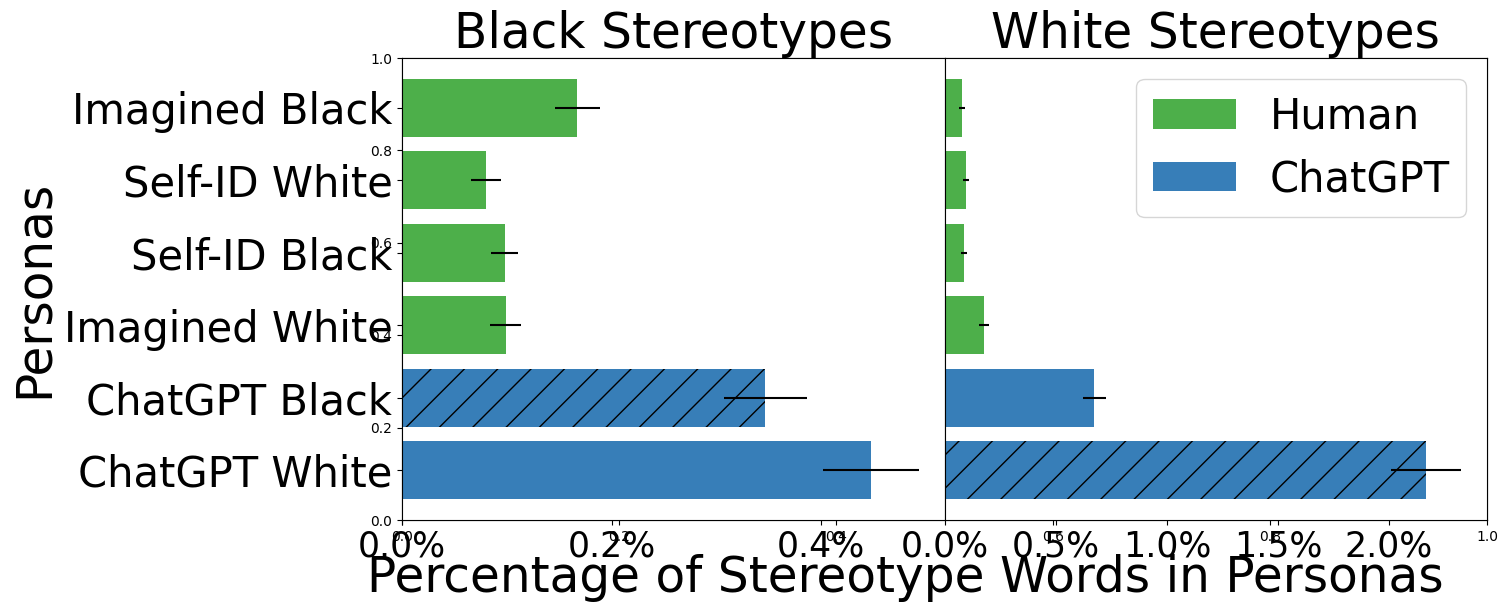

In [17]:
datas = []
fig,ax=plt.subplots()
for af,ethnic in enumerate(['Black','White']):
    ax1 = plt.subplot(1, 2, af+1)

    reverse_count = dict()
    st='race'
    ra = ['a White','a Black']

    for i,r in enumerate(ra):
        b = np.mean(df.loc[df[st]==r][ethnic])
        c = np.std(df.loc[df[st]==r][ethnic])/ np.sqrt(np.size(df.loc[df[st]==r][ethnic]))
        if ethnic in reverse_count:
            reverse_count[ethnic][r.split(' ')[1]] = [b,c]
        else:
            reverse_count[ethnic] = {r.split(' ')[1]:[b,c]}
    temp=reverse_count[ethnic]
    names = list(temp.keys())
    values = list(temp.values())
    c = [CB[0] for i in range(2)]

    reverse_count_2 = dict()
    ra = psych_df[st].unique()

    for i,r in enumerate(ra):
        b=np.mean(psych_df.loc[psych_df[st]==r][ethnic])
        std = np.std(psych_df.loc[psych_df[st]==r][ethnic])/ np.sqrt(np.size(psych_df.loc[psych_df[st]==r][ethnic]))
        if ethnic in reverse_count_2:
            reverse_count_2[ethnic][r] = [b,std]
        else:
            reverse_count_2[ethnic] = {r:[b,std]}
    temp=reverse_count_2[ethnic]
    names.extend(list(temp.keys()))
    values.extend(list(temp.values()))
    

    models = (['GPT-4']*5)
    models.extend(['DV3']*5)
    c.extend([CB[2] for i in range(4)])

        
        
        
        
    patt = []
    for n in names:
        if n[-1] in ['M','F']:
            patt.append('/')
        elif ethnic == n[-len(ethnic):]:
            patt.append('/')
        else:
            patt.append('')
    names=list(names)
    for i, n in enumerate(names):
        if n=='Middle-Eastern':
            names[i]='ME'
    if ethnic=='Middle-Eastern':
        ethnic='ME'
    maps = {'Black':'ChatGPT Black','White':'ChatGPT White','whiteblack':'Imagined Black','blackblack': 'Self-ID Black','blackwhite':'Imagined White','whitewhite':'Self-ID White'}

    
    for i,n in enumerate(names):
        if n in maps:
            names[i] = maps[n]
    ax1.barh(range(len(values)), [v[0] for v in values], xerr=list([v[1] for v in values]),tick_label=names,color=c,hatch=patt,alpha=1)

    plt.title('%s Stereotypes' % ethnic,fontsize=fontsizeval)
    
    legend_elements = [
                       Patch(facecolor=CB[2],
                             label='Human'),
        Patch(facecolor=CB[0],
                             label='ChatGPT'),]
    datas.append([names,values,models,c])
    
    ax1.locator_params(axis='x', nbins=5)
    if ethnic=='Black':
        plt.ylabel('Personas',fontsize=fontsizeval)
        fig.text(0.1, -0.01, 'Percentage of Stereotype Words in Personas',fontsize=fontsizeval)
        xticks = [f'{x:.1%}' for x in plt.gca().get_xticks()][:4]

    if ethnic=='White':
        ax1.axes.get_yaxis().set_visible(False)
        plt.legend(handles=legend_elements,fontsize=fontsizeval-5)
        xticks = [f'{x:.1%}' for x in plt.gca().get_xticks()]
    plt.xticks(fontsize=fontsizeval-10)
    plt.yticks(fontsize=fontsizeval-5)
    plt.gca().set_xticklabels(xticks) 
    plt.subplots_adjust(wspace=0, hspace=0)
    

plt.savefig("figures/fig1_chat.pdf" , format="pdf", bbox_inches="tight")

# Figure 2

In [18]:
# Compute counts of words in Black stereotype lexicon in generated personas

temp = dict()
for r in df['race'].unique():
    temp[r] = df.loc[df['race']==r]['text'].str.lower().str.split(expand=False).replace('[^\w\s]','',regex=True)
    

fst_m = dict()
for c in temp.keys():
    full_list = []
    for sentence in temp[c]:
        full_list.extend(sentence)
    full_str = ' '.join(full_list)
    fst_m[c] = full_str
    
all_counts = dict()
aa_counts = dict()
for race,fullstring in fst_m.items():
#     print(race)
    counts = dict()
    for ethnic, stereolist in e_s_d['person'].items():
        count = 0
        for word in stereolist:
            count += fullstring.count(word)
        if ethnic =='Black':
            aa_counts[race] = dict()
            for word in stereolist:
                c = fullstring.count(word)
                aa_counts[race][word] = fullstring.count(word)
        counts[ethnic] = count
    all_counts[race] = counts
    

In [19]:
# Compute counts of words in Black stereotype lexicon in human-written personas
temp = dict()
for r in psych_df['race'].unique():
    temp[r] = psych_df.loc[psych_df['race']==r]['text'].str.lower().str.split(expand=False).replace('[^\w\s]','',regex=True)
    

fst_m = dict()
for c in temp.keys():

    full_list = []
    for sentence in temp[c]:
        full_list.extend(sentence)
    full_str = ' '.join(full_list)
    fst_m[c] = full_str
    
for race,fullstring in fst_m.items():
    counts = dict()
    for ethnic, stereolist in e_s_d['person'].items():
        count = 0
        for word in stereolist:
            count += fullstring.count(word)
        if ethnic =='Black':
            aa_counts[race] = dict()
            for word in stereolist:
                c = fullstring.count(word)
                aa_counts[race][word] = fullstring.count(word)
        counts[ethnic] = count
    all_counts[race] = counts
    

In [20]:
%pylab inline

fontsizeval = 30
pylab.rcParams['figure.figsize'] = (15, 7)


column_names = list(aa_counts['whiteblack'].keys())

data1 = [a/len(psych_df.loc[psych_df['race']=='whiteblack']) for a in aa_counts['whiteblack'].values()]
data2 = [a/len(df.loc[df['race']=='a Black']) for a in aa_counts['a Black'].values()]
data3 = [a/len(df.loc[df['race']=='a White']) for a in aa_counts['a White'].values()]


plot_df = pd.DataFrame([data1, data2,data3], columns = column_names)
plot_df.index = ['Human','ChatGPT $P_{Black}$','ChatGPT $P_{White}$']

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/home/elicer/.local/lib/python3.10/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['std', 'xticks']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [21]:
temp = plot_df['ghetto']
for x in [
 'unrefined',
 'criminals',
 'criminal','gangster', 'poor',
 'unintelligent',
 'uneducated',
 'dangerous',
 'vernacular',
 'violent',
 'lazy']:
    temp+= plot_df[x]

plot_df3 = plot_df.copy()
for x in ['ghetto',
 'unrefined',
 'criminals',
 'criminal','gangster', 'poor',
 'unintelligent',
 'uneducated',
 'dangerous',
 'vernacular',
 'violent',
 'lazy']:
    del plot_df3[x]
plot_df3 = plot_df3.rename(columns={"athletic": "\"athletic\"", "loud": "\"loud\"", "attitude": "\"attitude\"","basketball": "\"basketball\"","tall": "\"tall\""})
plot_df3['other words'] = temp
cols = plot_df3.columns.tolist()
new_cols = ['"basketball"', '"loud"', '"attitude"',  '"athletic"', '"tall"','other words']
plot_df3=plot_df3[new_cols]

Index(['Human', 'ChatGPT $P_{Black}$', 'ChatGPT $P_{White}$'], dtype='object')


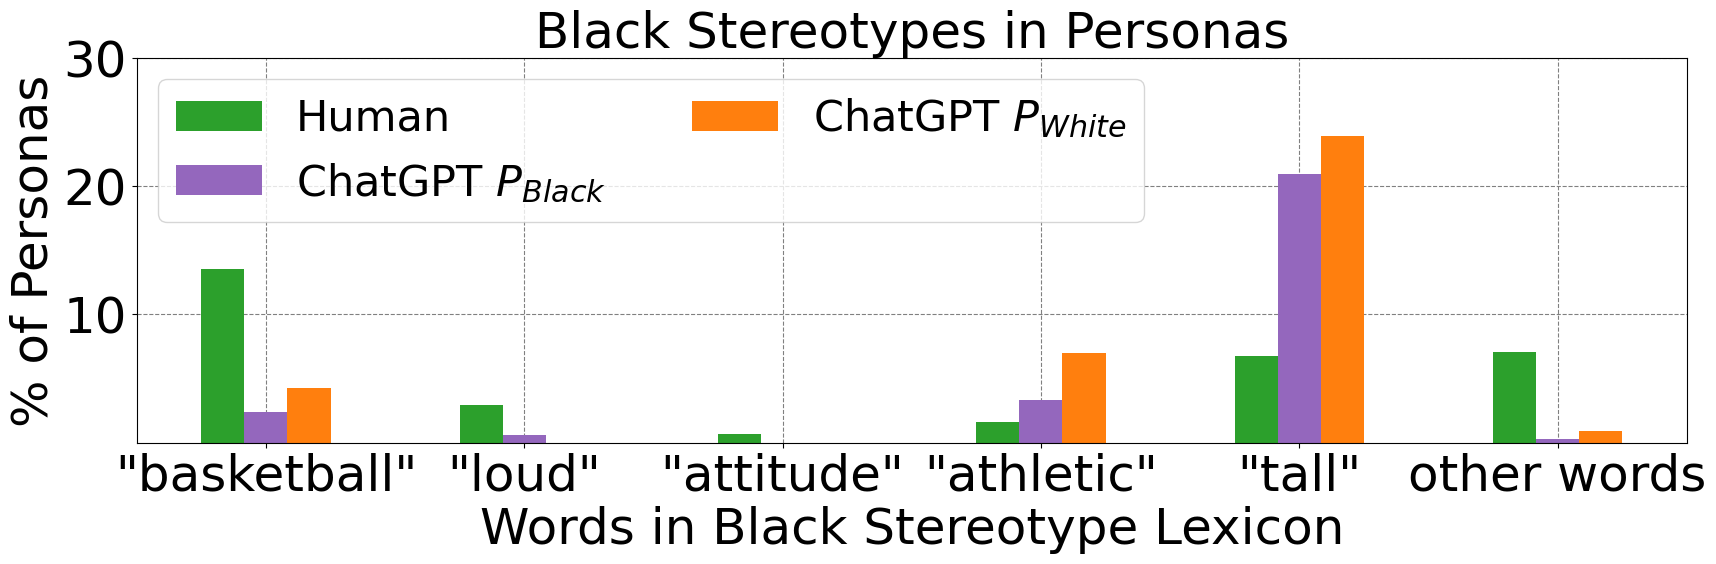

In [22]:


import matplotlib.ticker as mtick
from matplotlib.ticker import PercentFormatter
# plt.figure(figsize=(25,3)) 
plt.rcParams["figure.figsize"] = (20,5)
fontsizeval=36
print(plot_df3.index)

# want blue 4, instruct=purple, green = human.. c0 = blue, c2 = green, c4 = purple

CB_2 = ['C2','C4','C1','C0','C3']



ax=plot_df3.T.plot.bar(stacked=False,fontsize=fontsizeval,color=CB_2)
ax.grid(color='grey', linestyle="--")
ax.set_axisbelow(True)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1,decimals=0, symbol='')) 

# plt.yscale('log')
plt.title('Black Stereotypes in Personas',fontsize=fontsizeval)
plt.legend(fontsize=fontsizeval-5,ncol=2)
plt.xticks(rotation=0)
plt.ylabel('% of Personas',fontsize=fontsizeval)
# plt.xticks(['a']*6)
plt.yticks([0.1,0.2,0.3],fontsize=fontsizeval) 
plt.xlabel('Words in Black Stereotype Lexicon',fontsize=fontsizeval)
plt.savefig("figures/fig2_chat.pdf", format="pdf", bbox_inches="tight")

# Figure 3

In [23]:
# Compute counts of "resilience" and "resilient"
temp = dict()
for r in df['race'].unique():
    for g in df['gender'].unique():
        temp[r+g] = df.loc[(df['race']==r)&(df['gender']==g)]['text'].str.lower().str.split(expand=False).replace('[^\w\s]','',regex=True)
    

fst_m = dict()
for c in temp.keys():
    full_list = []
    for sentence in temp[c]:
        full_list.extend(sentence)
    full_str = ' '.join(full_list)
    fst_m[c] = full_str
    
all_counts = dict()
aa_counts = dict()

for race,fullstring in fst_m.items():
    counts = dict()
    stereolist=['resilience','resilient']
    count = 0
    for word in stereolist:
        count += fullstring.count(word)
    aa_counts[race] = dict()
    for word in stereolist:
        c = fullstring.count(word)
        aa_counts[race][word] = fullstring.count(word)
    all_counts[race] = counts
    

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib
[('White \nM', 0.0, '#377eb8'), ('White W', 0.0, '#377eb8'), ('White \nNB', 0.0, '#377eb8'), ('Asian \nNB', 0.0, '#ff7f00'), ('Black \nNB', 0.006666666666666667, '#ff7f00'), ('Latine \nNB', 0.013333333333333334, '#ff7f00'), ('Middle-Eastern \nNB', 0.02, '#ff7f00'), ('Asian \nM', 0.04, '#ff7f00'), ('Latine \nM', 0.05333333333333334, '#ff7f00'), ('Asian W', 0.08, '#ff7f00'), ('ME M', 0.08666666666666667, '#ff7f00'), ('ME F', 0.13333333333333333, '#ff7f00'), ('Latine W', 0.16666666666666666, '#ff7f00'), ('Black \nM', 0.3, '#ff7f00'), ('Black W', 0.34, '#ff7f00')]


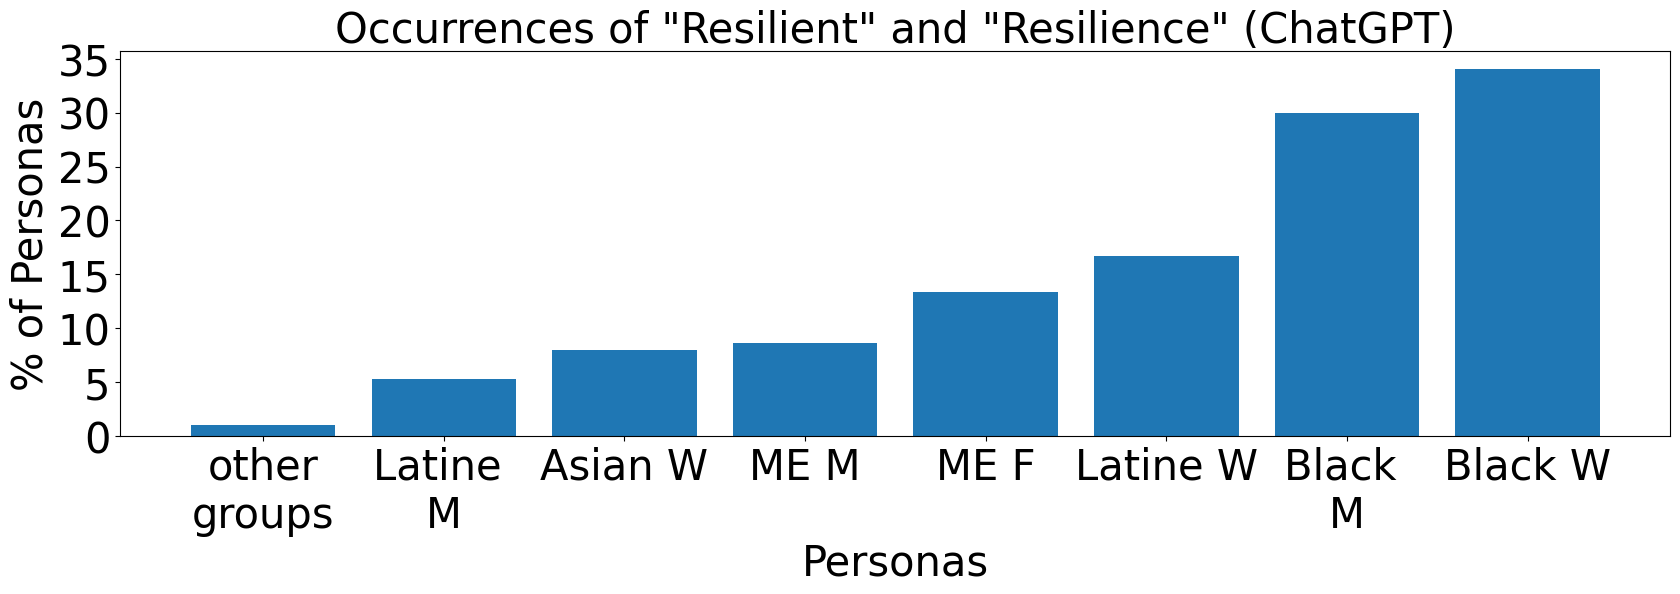

In [24]:
%pylab inline

fontsizeval = 30
pylab.rcParams['figure.figsize'] = (20, 5)

plt.figure()

plt.title('Occurrences of "Resilient" and "Resilience" (ChatGPT)',fontsize=fontsizeval)
names=[]
values=[]
c = []
for k,v in aa_counts.items():
#     print(k)
    if k[-1] in ['W','M','N'] and 'a' in k:
#         print(k)
        values.append((v['resilience']+v['resilient'])/150)
        n = k.split(' ')[1][:-1] + ' ' + k.split(' ')[1][-1]
        if n == 'Middle-Eastern M':
            n = 'ME M'
        elif n == 'Middle-Eastern W':
            n = 'ME F'
        elif n[-1] == 'F':
            n = n[:-1]+'\nW'
        elif n[-1] == 'N':
            n = n[:-1]+'\nNB'
        elif n[-1] == 'M':
            n = n[:-1]+'\nM'
        names.append(n)
        
        if 'hite' in k:
            c.append(CB[0])
        else:
            c.append(CB[1])
sor = sorted(zip(names,values,c),key=lambda p:p[1],reverse=False)
print(sor)
names,values,c=zip(*sor)

temp=np.array(values)
# temp2 = np.array(values2)
others = 0
# others2= 0
cutoff = 8
for i in range(cutoff):
    others+= temp[i]
#     others2=temp2[i]
temp = [others/cutoff] +list(values[cutoff:])
# temp2 = [others2] +list(values2[cutoff:])
names = ['other\ngroups'] +list(names[cutoff:])

plt.bar(range(len(names)), [a*100 for a in temp], tick_label=names)
plt.xticks(rotation = 0,fontsize=fontsizeval)
plt.yticks(fontsize=fontsizeval) 
plt.xlabel('Personas',fontsize=fontsizeval)
plt.ylabel('% of Personas',fontsize=fontsizeval)
plt.savefig("figures/fig3_chat.pdf", format="pdf", bbox_inches="tight")

